## This file is modified based on new understandings and methodologies since the original implementation (2 years later)

**The primary purpose of this study was to assess the rates of adolescent maternal mortality within Mexico, and calculate the risk probability of an adolescent maternal mortality by region in Mexico based on some of the top features contributing to maternal mortality.**

In [4]:
# Import the relevant modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

# Machine Learning modules
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.naive_bayes import GaussianNB

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# ROC Curve
from sklearn.metrics import roc_curve

# Scale Data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [116]:
# Open merged materna_mortal_factors dataset
%store -r materna
data = materna.drop(['Date of Birth','Residence Name', 'Local Community Size', 'Education Completed'], axis=1)
print(data.shape)
data.head(10)

(16631, 5)


,Residence Code,Local Size Code,Education Code,Age at Death,Medical Assistance Received
0,7,1,2,11,CON ATENCION MEDICA
1,30,11,3,12,CON ATENCION MEDICA
2,27,14,4,12,CON ATENCION MEDICA
3,15,4,5,12,CON ATENCION MEDICA
4,12,4,2,12,SIN ATENCION MEDICA
5,12,1,2,12,CON ATENCION MEDICA
7,15,5,2,12,CON ATENCION MEDICA
8,7,8,2,12,CON ATENCION MEDICA
9,30,9,3,12,CON ATENCION MEDICA
10,3,0,2,13,CON ATENCION MEDICA


In [117]:
data.dtypes

Residence Code                  int64
Local Size Code                 int64
Education Code                  int64
Age at Death                    int64
Medical Assistance Received    object
dtype: object

In [118]:
medical_col = []
for med in data['Medical Assistance Received']:
    
    if med == 'CON ATENCION MEDICA':
        medical_col.append(1)
    else:
        medical_col.append(0)

data['Medical Assistance Received'] = pd.Series(medical_col)
data.head()

,Residence Code,Local Size Code,Education Code,Age at Death,Medical Assistance Received
0,7,1,2,11,1.0
1,30,11,3,12,1.0
2,27,14,4,12,1.0
3,15,4,5,12,1.0
4,12,4,2,12,0.0


In [119]:
target_col = []
for age in data['Age at Death']:
    
    if age < 28.36:
        target_col.append(1)
    else:
        target_col.append(0)

data['Below μ Age in Mexico'] = pd.Series(target_col)
data.head()

,Residence Code,Local Size Code,Education Code,Age at Death,Medical Assistance Received,Below μ Age in Mexico
0,7,1,2,11,1.0,1.0
1,30,11,3,12,1.0,1.0
2,27,14,4,12,1.0,1.0
3,15,4,5,12,1.0,1.0
4,12,4,2,12,0.0,1.0


In [120]:
data.isnull().sum()

Residence Code                    0
Local Size Code                   0
Education Code                    0
Age at Death                      0
Medical Assistance Received    1338
Below μ Age in Mexico          1338
dtype: int64

In [121]:
data = data.fillna(value=0)

### Dataset Target Variable: Below μ Age in Mexico

In [122]:
data = data.drop(columns=['Age at Death'], axis=1)
data_encoded = pd.get_dummies(data)
data_encoded.head()

,Residence Code,Local Size Code,Education Code,Medical Assistance Received,Below μ Age in Mexico
0,7,1,2,1.0,1.0
1,30,11,3,1.0,1.0
2,27,14,4,1.0,1.0
3,15,4,5,1.0,1.0
4,12,4,2,0.0,1.0


In [123]:
data_encoded.isnull().sum()

Residence Code                 0
Local Size Code                0
Education Code                 0
Medical Assistance Received    0
Below μ Age in Mexico          0
dtype: int64

In [124]:
# Entire dataset (excluding response variable)
X = data_encoded.copy().drop(['Below μ Age in Mexico'], axis=1)

# The response variable
y = data_encoded.copy().pop('Below μ Age in Mexico')

## Assess potential correlation of various factors within each Region
- Create a correlation dataframe
- Plot the correlation dataframe on a sns heatmap:
    - Cells that are in green show positive correlation
    - Cells that are in red show negative correlation

<AxesSubplot:>

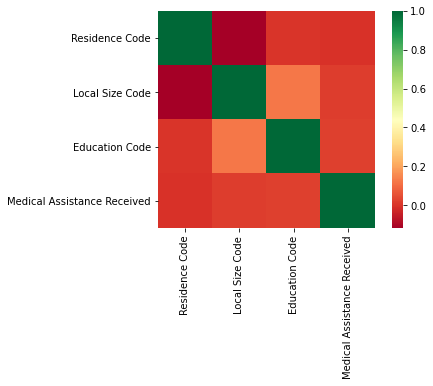

In [125]:
# Create a correlation dataframe
feature_corr = X.corr()

# Plot a correlation heatmap
sns.heatmap(feature_corr, square=True, cmap='RdYlGn')

In [126]:
X.corr()

,Residence Code,Local Size Code,Education Code,Medical Assistance Received
Residence Code,1.000000,-0.118064,0.002606,-0.002192
Local Size Code,-0.118064,1.000000,0.125322,0.020246
Education Code,0.002606,0.125322,1.000000,0.023783
Medical Assistance Received,-0.002192,0.020246,0.023783,1.000000


In [127]:
y.isna().sum()

0

#### Assess number of rows per target output

In [128]:
data_encoded[['Below μ Age in Mexico', 'Medical Assistance Received']].groupby('Below μ Age in Mexico',
                                                 as_index=False).count()

,Below μ Age in Mexico,Medical Assistance Received
0,0.0,8846
1,1.0,7785


## Prepare Data for Logisitic Regression Machine Learning Model

#### Purpose for Changing all Categorical Strings to a Numeric Value: 
- Machine Learning models will ignore string values (strings have no statistical value unless added)
- Numeric values are comparable therefore string values should be categorically changed to numbers
- This is how you compare a string value to a numeric value that the model can use

# Basic Logistic Regression: 
* **Target Variable: Above(0)/Not(1) MeEX μ *(age maternal mortality)***
* Split the data into a training and test (hold-out) set
* Train on the training set, and test for accuracy on the testing set

In [129]:
# Create a Logistic Regression Incidence 
clf_log = LogisticRegression(random_state=42, solver='lbfgs')

#### Test-Train-Split:
- X = copy of all features of dataset
- y = all features within dataset *excluding the response (target) variable*
- test_size = represents the proportion of the dataset (as a percentage) to include in the test split
- random_state = the seed used by the random number generator

In [130]:
list(X.columns)

['Residence Code',
 'Local Size Code',
 'Education Code',
 'Medical Assistance Received']

In [131]:
# Create train and test data sets with train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(11641, 4990, 11641, 4990)

**Classification Report Conclusion for Unscaled Data**: The Logistic Regression model produced a 0% percision, recall, and F1-score for all instances of '1' for the target variable, 'Above(0)/Not(1) MEX μ' *(age maternal mortality)* while producing a 57% percision, 80% recall, and 67% F1-score for instances of '0' for the target variable. This means that the model, while marginally accurate for detecting Regions with a μ Age Maternal Mortality that is above the μ Age Maternal Mortality in Mexico, is not a fully-encompassing model since it cannot accurately detect the when a region is below the country mean.

# Scaled Data
Being that there are only 28 rows within this dataset (one per State in Mexico), this data requires standard scaling to amplofy the impact of the predictive logistic model.

#### Scale Data for Logistic Regression with Standard Scaler and Pipeline

In [132]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('log', LogisticRegression(random_state=42, solver='lbfgs'))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

#### Logistic Regression with Scaled Data

In [133]:
y_train

array([0., 1., 1., ..., 1., 1., 0.])

In [134]:
# Fit the pipeline to the training set: clf_log_scaled
clf_log_scaled = pipeline.fit(X_train, y_train)
clf_log_scaled

Pipeline(steps=[('scaler', StandardScaler()),
                ('log', LogisticRegression(random_state=42))])

In [135]:
# Calculate the class probablity -returns the probability of model's ability to predict a likely value of the features
probability = clf_log_scaled.predict_proba(X_test)
probability

array([[0.49244304, 0.50755696],
       [0.49153003, 0.50846997],
       [0.48904214, 0.51095786],
       ...,
       [0.48774135, 0.51225865],
       [0.49521495, 0.50478505],
       [0.48719106, 0.51280894]])

In [136]:
X.columns.values

array(['Residence Code', 'Local Size Code', 'Education Code',
       'Medical Assistance Received'], dtype=object)

In [137]:
# rename columns for visual
X.columns.values

feature_names = ['State', 'State Population 2015', 'Sample Size', 'μ Age Variance','Region Mode Education Level',
       'Most Common Region Local Community Size',
       'Received Medical Assist']

In [138]:
# Get the feature coefficients
coefs = clf_log_scaled.named_steps['log'].coef_.flatten()

# Zip coefficients and names together and make a DataFrame
zipped = zip(X.columns.values, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])

# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)
df

,feature,value,abs_value,colors
3,Medical Assistance Received,0.339775,0.339775,green
2,Education Code,0.060676,0.060676,green
0,Residence Code,-0.028694,0.028694,red
1,Local Size Code,-0.008516,0.008516,red


Text(0.5, 0, 'Feature Name')

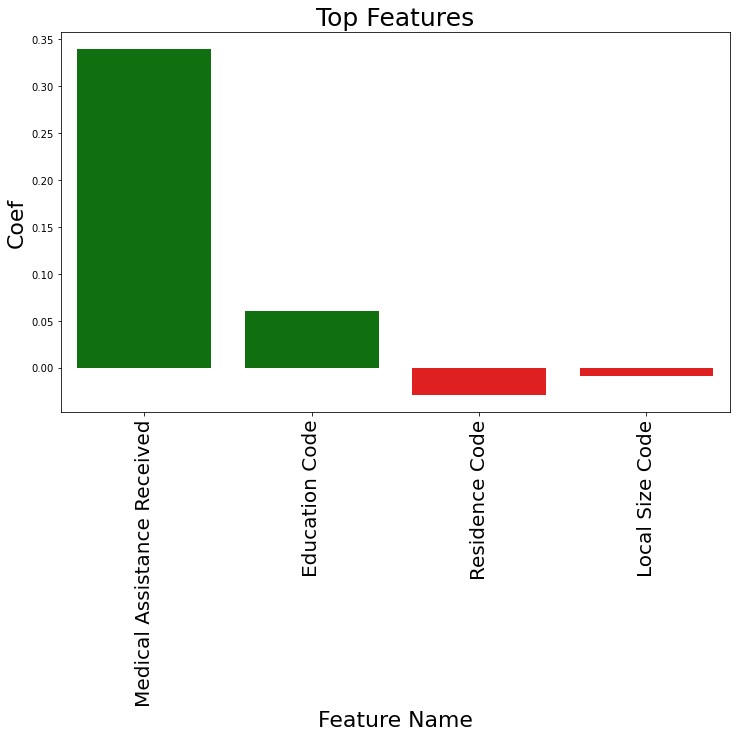

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(20),
           palette=df.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

Observations: So we can see that positive unigrams seem to be the most impactful.

#### Classification Report
- **Precision**: 
    - positive predictive value
    - total number predicted correctly
- **Recall**: 
    - model sensitivity 
    - the fraction of the relevant documents that are successfully retrieved
- **F1-score**:
    - single measurement of system
    - provide a single measurement for a system

In [140]:
# Predict the model -assess how well the model predicts unseen data
predict_scaled = clf_log_scaled.predict(X_test)

# Compute classification report (https://en.wikipedia.org/wiki/Precision_and_recall)

class_report = classification_report(y_test, predict_scaled)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.59      0.43      0.50      2628
         1.0       0.51      0.67      0.58      2362

    accuracy                           0.54      4990
   macro avg       0.55      0.55      0.54      4990
weighted avg       0.55      0.54      0.54      4990



**Classification Report Conclusion for Scaled Data**: The Logistic Regression model produced a 100% percision, 67% recall, and 80% F1-score for all instances of '1', and a 83% percision, 100% recall, and 91% F1-score for all instances of '0' of the target variable. This means that the model appears to identify Regions with a μ Age Maternal Mortality that *is* or *is not* above the μ Age Maternal Mortality in Mexico with marginal to somewhat reliable accuracy.

[[1137 1491]
 [ 790 1572]]


<AxesSubplot:>

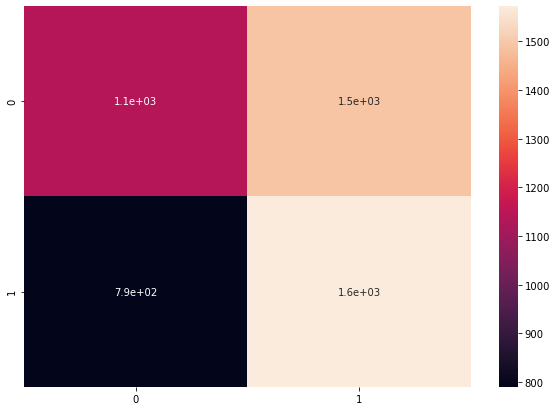

In [141]:
# Compute the confusion_matrix to evaluate the accuracy of a classification
conf_matrix = confusion_matrix(y_test, predict_scaled)
print(conf_matrix)

# Plot confusion_matrix
plt.figure(figsize = (10,7))
sns.heatmap(conf_matrix, annot=True)

In [142]:
# Print the accuracy from the testing data
'The accuracy score the the scaled data is: ', accuracy_score(y_test, predict_scaled)

('The accuracy score the the scaled data is: ', 0.5428857715430861)

In [143]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob_scaled = clf_log_scaled.predict_proba(X_test)[:,1]

# Compute and print AUC score
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob_scaled)))

# Compute cross-validated AUC scores: cv_auc
cv_auc = cross_val_score(clf_log_scaled, X, y, scoring='roc_auc', cv=5)

# Print list of AUC scores
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.5632984101392289
AUC scores computed using 5-fold cross-validation: [0.47214348 0.49450629 0.5195619  0.53710336 0.28299193]


#### Visualize Logistic Regression Model Accuracy for the Scaled Data with ROC curve

Text(0.5, 1.0, 'ROC Curve')

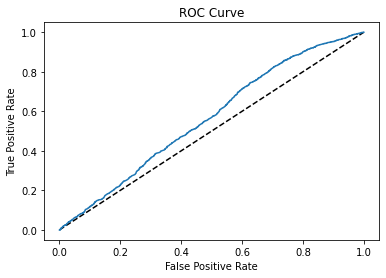

In [144]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_scaled)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

#### Visualize our true vs. predicted values

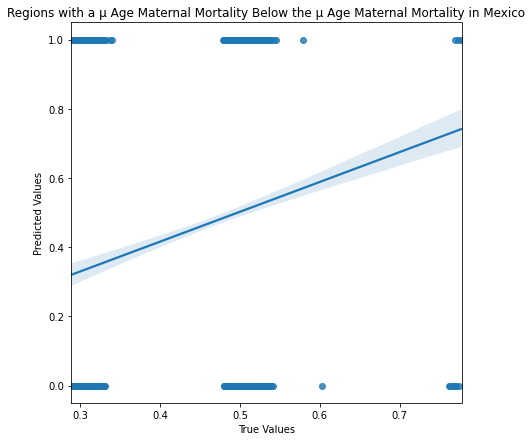

In [145]:
plt.figure(figsize=(7,7))
plt.title('Regions with a μ Age Maternal Mortality Below the μ Age Maternal Mortality in Mexico')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
fig=sns.regplot(x=y_pred_prob_scaled, y=y_test)
plt.show(fig)